In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

# Helper functions

In [2]:
def construct_laplacian_kernel_matrix(N, h):
    # Construct the matrix that defines the linear system

    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)
    
    return rows, cols, values

# Sparse solver

In [3]:
def sparse_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = scipy.sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    # Solve the sparse linear system
    psi = scipy.sparse.linalg.spsolve(
        A=kernel_matrix_sparse,
        b=-w[1:-1, 1:-1].flatten().reshape((N ** 2, 1))
    )
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


# Newton's iteration

In [4]:
# Given the vorticity, solve the Poisson eqn. to find the streamfunction

def get_jacobian(N, h):
    # Construct the sparse matrix
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)

    # Create the sparse matrix from the above information
    return scipy.sparse.csc_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    

def f(x, w, h):
    # this N is different from before
    N = int(np.sqrt(x.shape[0]))
    
    x = x.reshape(N, N)
    x = np.pad(x, (1, 1), mode="constant", constant_values=0)
    
    f = -4 * x[1:-1, 1:-1] + x[2:, 1:-1] + x[:-2, 1:-1] + x[1:-1, 2:] + x[1:-1, :-2]
    f = f + h ** 2 * w[1:-1, 1:-1]
    
    return f.reshape((-1, 1))


def newton_iterator(x, f, J, w, N, h, TOL=1e-8, max_iter=10, quiet=True):
    '''
        - x: initial guess
        - f: evaluates the function given x, w, h
        - J: evaluates the Jacobian given N, h
        - w: vorticity
        - N: number of grid points
        - h: grid size
    '''
    
    n_iter = 0 # number of iterations
    
    # Initialization
    f_current = f(x, w, h)
    
    # Check if the initial guess is a solution
    f_norm = scipy.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter
    
    
    while n_iter < max_iter:
        n_iter += 1
        # Set h=1 to have better scaling and not that we actually compute h ** 2 * f_current
        Jacobian = J(N=N - 1, h=1)
        
        dx = scipy.sparse.linalg.spsolve(Jacobian, -f_current).reshape((-1, 1))
        x_next = x + dx
        
        f_current = f(x_next, w, h)
        
        f_norm = scipy.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
        if f_norm <= TOL:
            break
        
        x = x_next
    
    if not quiet:
        print(f"n_iter={n_iter}")
    
    return x_next, n_iter



def newton_solver(w, TOL=1e-8, max_iter=10, quiet=True):
    N = w.shape[0] - 1
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N
    
    # Initialization
    x0 = np.zeros(((N - 1) ** 2, 1))

    solution, n_iter = newton_iterator(
        x=x0, f=f, J=get_jacobian,
        w=w, N=N, h=h,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )
    
    psi = solution.reshape(N - 1, N - 1)

    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    return psi


In [5]:
# # Given the vorticity, solve the Poisson eqn. to find the streamfunction

# def get_jacobian(N, h):
#     # Construct the sparse matrix
#     rows, cols, values = construct_laplacian_kernel_matrix(N, h)

#     # Create the sparse matrix from the above information
#     return scipy.sparse.csc_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    

# def f(x, w, h):
#     # this N is different from before
#     N = int(np.sqrt(x.shape[0]))
    
#     x = x.reshape(N, N)
#     x = np.pad(x, (1, 1), mode="constant", constant_values=0)
    
#     f = -4 * x[1:-1, 1:-1] + x[2:, 1:-1] + x[:-2, 1:-1] + x[1:-1, 2:] + x[1:-1, :-2]
#     f = f + h ** 2 * w[1:-1, 1:-1]
    
#     return f.reshape((-1, 1))


# def newton_iterator(x, f, J, w, N, h, TOL=1e-8, max_iter=10, quiet=True):
#     '''
#         - x: initial guess
#         - f: evaluates the function given x, w, h
#         - J: evaluates the Jacobian given N, h
#         - w: vorticity
#         - N: number of grid points
#         - h: grid size
#     '''
    
#     count = 0 # number of iterations
    
#     # Initialization
#     f_current = f(x, w, h)
    
#     # Check if the initial guess is a solution
#     f_norm = scipy.linalg.norm(f_current)
#     if f_norm <= TOL:
#         if not quiet:
#             print(f"count={count}")

#         return x, count
    
    
#     while count < max_iter:
#         count += 1
#         # Set h=1 to have better scaling and not that we actually compute h ** 2 * f_current
#         Jacobian = J(N=N - 1, h=1)
        
#         dx = scipy.sparse.linalg.spsolve(Jacobian, -f_current).reshape((-1, 1))
#         x_next = x + dx
        
#         f_current = f(x_next, w, h)
        
#         f_norm = scipy.linalg.norm(f_current)
#         if not quiet:
#             print(f"iter={count}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
#         if f_norm <= TOL:
#             break
        
#         x = x_next
    
#     return x_next, count



# def newton_solver(w, TOL=1e-8, max_iter=10, quiet=True):
#     N = w.shape[0] - 1
#     nx = N + 1
#     ny = N + 1 # = nx

#     h = 1 / N
    
#     # Initialization
#     x_current = np.zeros(((N - 1) ** 2, 1))
#     f_current = f(x_current, w, h)
    
#     count = 0
    
#     # Check if the initial guess is a solution
#     f_norm = scipy.linalg.norm(f_current)
#     if f_norm <= TOL:
#         if not quiet:
#             print(f"count={count}")

#         return np.pad(
#             x_current.reshape(N - 1, N - 1),
#             (1, 1), mode="constant", constant_values=0
#         )
    
    
#     while count < max_iter:
#         count += 1
#         # Set h=1 to have better scaling and not that we actually compute h ** 2 * f_current
#         Jacobian = get_jacobian(N=N - 1, h=1)
        
#         dx = scipy.sparse.linalg.spsolve(Jacobian, -f_current).reshape((-1, 1))
#         x_next = x_current + dx
        
#         f_current = f(x_next, w, h)
        
#         f_norm = scipy.linalg.norm(f_current)
#         if not quiet:
#             print(f"iter={count}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
#         if f_norm <= TOL:
#             break
        
#         x_current = x_next
    
#     if not quiet:
#         print(f"count={count}")
        
#     psi = x_next.reshape(N - 1, N - 1)

#     psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
#     return psi


In [6]:
# def newton_solver_2(w, TOL=1e-8, max_iter=10, quiet=True):
#     N = w.shape[0] - 1
#     nx = N + 1
#     ny = N + 1 # = nx

#     h = 1 / N
    
#     # Initialization
#     x_current = np.zeros(((N - 1) ** 2, 1))
#     f_current = f(x_current, w, h)
    
#     count = 0
#     while count < max_iter:
#         count += 1
        
#         Jacobian_inv = scipy.sparse.linalg.inv(get_jacobian(N=N - 1, h=h))
        
#         x_next = x_current - Jacobian_inv.dot(f_current)
        
#         f_current = f(x_next, w, h)
        
#         f_norm = scipy.linalg.norm(f_current)
#         x_norm = scipy.linalg.norm(x_next - x_current)
#         if f_norm <= TOL or x_norm <= TOL:
#             break
        
#         x_current = x_next
    
#     if not quiet:
#         print(f"count={count}")
        
#     psi = x_next.reshape(N - 1, N - 1)

#     psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
#     return psi

In [7]:
# # Initialize grid and the value of the vorticity on it
# nx = ny = 21
# h = 1 / 20
# x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
# w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

# # Solve the system
# psi_1 = sparse_solver(w)
# psi_2 = newton_solver(w, quiet=False)
# psi_3 = newton_solver_2(w, quiet=False)

In [8]:
# np.allclose(psi_1, psi_2), np.allclose(psi_2, psi_3), np.allclose(psi_1, psi_3)

1. First try just multiplying the whole eqn. by $h^2$ did not seem to work. N = 325 is when it starts to break. It was worse before, but still does not work.
1. Smarter approach works up to N=1000?

In [9]:
%%time

# Initialize grid and the value of the vorticity on it
N = 100
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

# Solve the system
psi_1 = sparse_solver(w)
psi_2 = newton_solver(w, quiet=False)
np.allclose(psi_1, psi_2)

iter=1; residual=2.8962033290147935e-14; dx=50.00411253811022
n_iter=1
CPU times: user 386 ms, sys: 575 ms, total: 962 ms
Wall time: 446 ms


True

In [10]:
psi = psi_2

In [11]:
abs_err = 0
for i in range(nx):
    for j in range(ny):
        abs_err = max(abs(psi[i, j] - np.sin(np.pi * i * h) * np.sin(np.pi * j * h)), abs_err)

print(f"abs_err = {abs_err}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

abs_err = 8.225076220269578e-05; psi(0.5, 0.5) = 1.0000822507622027


In [12]:
abs_err = np.max(np.abs(psi - np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)))
abs_err

8.225076220269578e-05

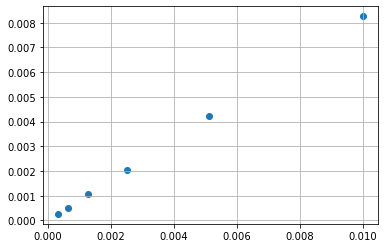

In [13]:
# error dependence on h

errors = []
N_values = np.array([10, 14, 20, 28, 40, 56])
for N_value in N_values:
    nx = ny = N_value + 1
    h = 1 / N_value
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
    
    psi = sparse_solver(w)                
    
    abs_err = 0
    for i in range(nx):
        for j in range(ny):
            abs_err = max(abs(psi[i, j] - np.sin(np.pi * i * h) * np.sin(np.pi * j * h)), abs_err)
    errors.append(abs_err)
    
plt.scatter(1 / N_values ** 2, errors)
plt.grid()
# plt.legend()
plt.show()    

In [14]:
(slope, intercept), fit_errors = np.polyfit(1 / N_values ** 2, errors, deg=1, cov=True)
print(f"Estimated slope is: {slope} +- {fit_errors[0, 0]}")

Estimated slope is: 0.8266454126956748 +- 2.7841933441752456e-07


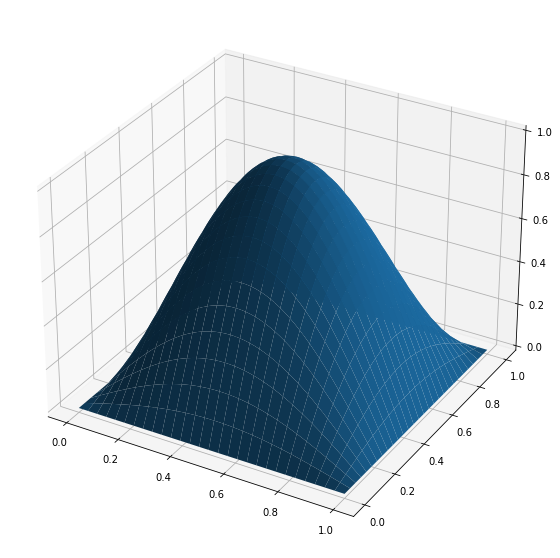

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

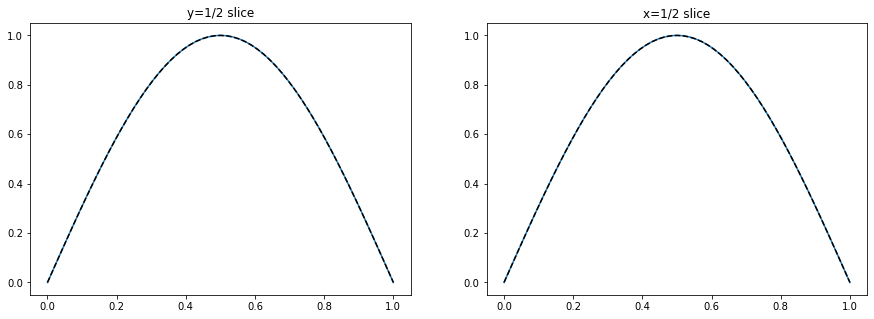

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[:, 0], psi[:, ny // 2])
ax1.plot(x_grid[:, 0], np.sin(np.pi*x_grid[:, 0]), "--", color="black")
ax1.set_title("y=1/2 slice")

ax2.plot(y_grid[0, :], psi[nx // 2, :])
ax2.plot(y_grid[0, :], np.sin(np.pi*y_grid[0, :]), "--", color="black")
ax2.set_title("x=1/2 slice")

plt.show()

In [18]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((28, 28), 1.00026230754872)

In [19]:
# Check the case w = 0 implies psi = 0

# Initialize grid and the value of the vorticity on it
nx = ny = 336
h = 1 / 20
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
w = np.zeros((nx, ny)) # vorticity

# Solve the system
psi_1 = sparse_solver(w)
psi_2 = newton_solver(w)

np.any(psi_1), np.any(psi_2)

(False, False)

# Speed comparison

In [20]:
# %%time

# N_values = np.array([7, 14, 28, 56, 84, 112, 224, 336, 448])
# N_values = np.array([7, 14, 28, 56])
# N_values = np.array([7, 14, 28])

# plt.figure(figsize=(10, 6))

# for method_name, method in [
#     ("sparse", sparse_solver), ("newton", newton_solver), ("newton2", newton_solver_2)
# ]:
#     print(method_name)
#     times = []
#     errors = []
    
#     for N in N_values:
#         print(N)

#         nx = ny = N + 1
#         h = 1 / N
#         x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
#         w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
        
#         time = %timeit -o -q method(w)
#         times.append(time.average)
#         errors.append(time.stdev)

#     plt.errorbar(x=N_values, y=times, yerr=errors, label=method_name)
#     print()

# # plt.xscale("log")
# plt.legend()
# plt.show()